# Cat or Dog Classifier with Transfer Learning
In the previous lesson built a classifer to classify an image as either containing a cat or a dog using a CNN network. Performance was probably ok (depending on how your network was constructed) but probably took a long time to train really well.

Part of the challenge is that we are starting from scratch with our learning, so our network must learn the basic building blocks of images each time we want to build our classifer (or some other type of model).

Another issue is that to train models for image tasks that need to perform really well you need to train very deep networks and train for a long time. Tranining very deep networks can be tricky and after hours of training the model can suddenly collapse and fail to learn anything useful.

Thankfully we have another option, we can build our classifer on top of a pre-trained network that is trained on a similar task. In our case we want a pre-trained network that has been trained to detect features in images and has been trained really well.

This is known as __Transfer Learning__. So in this workbook we will re-build our Cats or Dog classifier using transfer learning.

The early parts of this workbook are the same as the previous workbook so you can simply run these up to the point where we are building our network.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from keras.preprocessing import image

%matplotlib inline

TensorFlow version is  2.0.0-beta1


Using TensorFlow backend.


## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [2]:
def getCatsAndDogsData():
  # Download and extract the Data Set
  zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                    fname="cats_and_dogs_filtered.zip", extract=True)

  # Grab the location of the unzipped data
  base_dir, _ = os.path.splitext(zip_file)

  # Define the path to the Training and Validation Datasets
  train_dir = os.path.join(base_dir, 'train')
  validation_dir = os.path.join(base_dir, 'validation')

  return train_dir, validation_dir

def getTrainingDirs(train_dir):
  # Directory with our training cat pictures
  train_cats_dir = os.path.join(train_dir, 'cats')
  print ('Total training cat images:', len(os.listdir(train_cats_dir)))

  # Directory with our training dog pictures
  train_dogs_dir = os.path.join(train_dir, 'dogs')
  print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

  return train_cats_dir, train_dogs_dir

def getValidationDirs(validation_dir):
   # Directory with our validation cat pictures
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

  # Directory with our validation dog pictures
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')
  print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

  return validation_cats_dir, validation_dogs_dir

def getCatsAndDogsImageNames(cats_dir, dogs_dir):
  train_cats_names = os.listdir(cats_dir)
  train_dogs_names = os.listdir(dogs_dir)

  return train_cats_names, train_dogs_names


def showImageGrid(image_dir, num_rows=2, num_cols=4):  
  image_labels = os.listdir(image_dir)
  num_pix = num_rows * num_cols
  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(num_cols * 4, num_rows * 4)

  pic_index += num_pix
  next_pix = [os.path.join(image_dir, fname) 
                  for fname in image_labels[pic_index-num_pix:pic_index]]
  
  for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(num_rows, num_cols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

def printLossAndAccuracy(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,max(plt.ylim())])
  plt.title('Training and Validation Loss')
  plt.show()
    
def predictImageContent(model):
  import numpy as np
  from google.colab import files
  from keras.preprocessing import image

  uploaded = files.upload()

  for fn in uploaded.keys():

    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
      print(fn + " is a dog")
    else:
      print(fn + " is a cat")


## Load the Data
The original dataset for this comes from https://www.kaggle.com/c/dogs-vs-cats

However we will use a smaller version of the dataset, this will enable us to train our model quicker rather than spending hours waiting for the training to complete.

The dataset is freely available as a zip file, so we need to download the file and then unzip it to the filesystem. Each image contains either a Cat or a Dog and is stored as a file.
The structure of the unzipped images will be:

`\train
        \train
                \cats
                \dogs
        \validation
                \cats
                \dogs`

The files under the __train__ folder will be used to train the model. This is split into __cats__ and __dogs__

The files under the __validation__ folder will be used to train the model. This is split into __cats__ and __dogs__

In [6]:
train_dir, validation_dir = getCatsAndDogsData()

train_cats_dir, train_dogs_dir = getTrainingDirs(train_dir)
validation_cats_dir, validation_dogs_dir = getValidationDirs(validation_dir)

train_cats_names, train_dogs_names = getCatsAndDogsImageNames(train_cats_dir, train_dogs_dir)

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


## Let's looks at some of the images

Training Cat Images


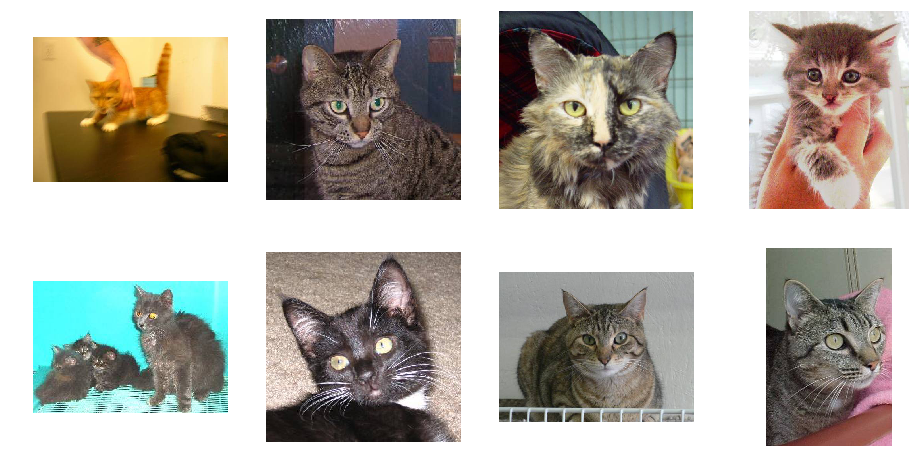

Training Dog Images


TypeError: listdir: path should be string, bytes, os.PathLike or None, not list

In [4]:
# Display some images from the Training folder
print("Training Cat Images")
showImageGrid(train_cats_dir, num_rows=2, num_cols=4)

print("Training Dog Images")
showImageGrid(train_dogs_dir, num_rows=2, num_cols=4)

You can see from this small sample of images that there is a great deal of variety in the images including:
- different sizes
- different backgrounds
- other objects (such as people's hands) in the image
- images of cats and dogs in different poses and angles

## Introduction to DataGenerators
Previously, we used datasets that were loaded directly into memory as an array of training samples but in the real-world it is more likely that we will have a set of images on a file-system. 

Additionally, given the size of typical image files we would not really want to load all the data into memory before we use it.

Luckily, Keras provides us with a setof  DataGenerator feature that allow use to effectively access training data images from folders as needed rather than reading all data in at once.

In this workbook we will be using the ImageDataGenerator and full details of this feature can be found at https://keras.io/preprocessing/image/

An ImageDataGenerator is a Image Pre-Processor that is designed to take images and prepare them for use in a network and it offers us a range of pre-processing options that are done in memory without affecting the source image on file. This includes:
- Resize the images
- Normalise the data
- Augment the data with random crops and transofmrations of the source image
- Batch the images ready for training.

### Pre-processing the images
The images in the dataset are of different sizes and use RGB (Red, Green, Blue) values between 0 and 255. As before we need to perform some pre-processing to:
- Resize the images to the same size
- Normalize the RGB values to the range 0 to 1

Since our data is already split into training and validation sets we will create two ImageDataGenerators; one for our training data and another for our validation data.

We will construct these ImageDataGenerators to:
- Normalise the data to the range 0 to 1
- Resize the images to 160 x 160
    - Images smaller than 160x160 will be enlarged
    - Images larger than 160x160 will be reduced
    - Non-Square images will be adjusted to be square
- Batch up our images for training

The configuration of the Data Generators might seem complex but hopefully will make sense

In [ ]:
# We want all our images to be re-sized to 160 x 160 pixels
image_size = 160

# For Training we want to use batches of 32 images at a time
batch_size = 32

### The Training Data Generator
The Training Data Generator will read images in batches from the Training Data folder and perform the pre-processing we need (re-sizing images and normalising the data)

In [ ]:
# Rescale all images by 1./255
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size = (image_size, image_size),
                batch_size = batch_size,
                # We are performing a Binary Classification
                class_mode = 'binary')

### The Validation Data Generator
The Validation Data Generator is almost identical to the Training Data Generator except that we obtain the data from a different folder in the file system

In [ ]:
# Rescale all images by 1./255
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                 # We are performing a Binary Classification
                class_mode='binary')

## Build our Model
To build a model using Transfer learning we need to:
- Create a Base Model to hold our pre-trained model
    - this model will act as a feature detector and extracts various new features about the images such as shapes, textures, lines, objects.
    - Since this is a pre-trained model we don't want to re-train the model (at least not initially)
- Add our custom layers after the pre-trained model as a classifier based on the detected features.
    - our classifer doesn't need to be particualrly deep
- Add our output layer to the model.

# Transfer Learning
The problem we are likely having is that when we are training our CNN layers are not deep enough and we are not trianing on a large enough dataset to really capture the local features of an immage.

One major trend in Deep Learning is to use general __Pre-trained__ models that have learned quite general features of, for example images, and use this as black box. This provides us with a general feature detector and we then bolt on a smaller network that, based on the outputs of the pre-trained network, learns our specific task. This process is known as __Transfer Learning__ and is likely (for the time being) to be the way that most of us will solve complex machine learning challenges.

These Pre-Trained Networks are trained using extermely large amounts of data, using very deep networks and trained for a long time. Training to such a level is likely beyond most of us due to the time and cost of doing this. However there are many such Pre-Trained networks available for free that we can use.

## Training using a Pre-Trained Network
When we build a network with a Pre-Train network we construct our network such that the Pre-Trained network is the initial layer (even although it's a whole network) and then add our own layers in sequence.

During our intial training of the network, do not train the Pre-Trained network (since it's already trained); we _freeze_ that layer and focus our training on the new layers we have added.

It may be that this is sufficient to get a really good model. If not we can choose to _unfreeze_ the Pre-Trained network and _fine tune_ the pre-trained network to our specific needs. This process is known as __Fine Tuning__.

When Fine-Tuning we have the choice of fine-tuning the whole of the Pre-Trained Network or a portion of the Pre-Trained Network.

For Pre-Trained Convolutional Networks, it is the case that early layers are good at detecting more general features such as lines, shadows, textures and so on which are general to most images whereas later layers become more specific and detect more complex features such as faces. So when _fine tuning_ for image problems we often only un-freeze the later levels to train them on our specific requirements.


## Pre-trained networks in Keras
In the remainder of this lesson we are going to use a Pre-Trained Network called __MobileNetV2__ which has been trained using a very large dataset called _ImageNet_.

Again, Keras makes this quite easy for us to do and we can create our base layer (a Pre-trained network) with a single line: ` tf.keras.applications.MobileNetV2()`.

Let's get to work

### Creating our Base Model from MobileNet
First we will create a _base model_ using the keras MobileNetV2 architecture.

Since it is pre-trained we will mark this model as not being trainable.

#### Exercise
We will print out the summary of the base model - review this model to appreciate the size and complexity of the pre-trained model we are using.


#### Question
What would happen if we made the base model trainable? How do you think it would affect the performance of the model during training and why?

In [ ]:
# Create our base layer (our Pre-Trained Network) 
# and freeze the model so that it does not change during traiing
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

### Create our Classifer model
Here we will create our model as normal - it only needs to be a small network since most of the hard work has already been done by the Base Model.

We create the model as a Sequential model as normal but instead of creating an Input layer we simply add our base layer as the first layer in our model.

After that we can create a new new layers to take the output from the base layer and classify the output.
 - Our classifer layers don't need to be too deep since the base layer has done most of the work for us.
 - We don't need to use Convolutional layers since the Base Model provides those for us


In [ ]:
transfer_model = tf.keras.Sequential()
# Add our base model (the pre-trained network)
transfer_model.add(base_model)

# Add our model
transfer_model.add(keras.layers.GlobalAveragePooling2D())

# TODO: add one or more Dense layers to classify the outputs from the base model
transfer_model.add(keras.layers.Dense(units=64, activation='relu'))

# Output layer
transfer_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile our model
transfer_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Train our Transfer Model
Training will be much slower than we have seen before because of the size of the network but beacuse we are using transfer learning we shouldn't need to train for very long.

In [ ]:
# Stop early if our Validation Loss stagnates
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

epochs = 5
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

transfer_history = transfer_model.fit_generator(train_generator,
                            steps_per_epoch = steps_per_epoch,
                            epochs=epochs,
                            workers=4,
                            validation_data=validation_generator,
                            validation_steps=validation_steps,
                            callbacks = [early_stop])

In [ ]:
printLossAndAccuracy(transfer_history)

## Evaluate our model
__In Practice - Never do this__.

The dataset we used did not have a seperate Testing set so will will evaluate against our validation set. In practice we should not do this as it's not a true measure of how our model generalises but it will give us some indication of accuracy and we are only learning. In our main Image Classification Project you will do this properly :-)


Similar to our Training and Validation ImageDataGenerators we will create a Test ImageDataGenerator and use the `model.evaluate_generator()` method to perform the evaluation against image files.

In [ ]:
# Test Generator
# Rescale all images by 1./255 - this shifts our data into the range 0-1
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Load Training images from our soruce folder in batches of 32 using train_datagen generator
test_datagen = test_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                 # We are performing a Binary Classification (Cat or Dog)
                class_mode='binary')

In [ ]:
# Test against our Test Set
loss, accuracy = model.evaluate_generator(test_generator)
print("Test Loss {:.4f}".format(loss))
print("Test Accuracy {:.3f}".format(accuracy))

### Exercise
How well has the model performed? Is it better than your previous CNN model?

## Let's Try a bit of Fine-Tuning
After we have performed our training it is sometimes possible to increase the accuracy further by fine-tuning.

Fine-tuning is is when we make our _Base Model_ trainable (or at least part of it) to make it more specialised to our classifier. We might do this because our pre-trained network is quite general and we want to tailor it to our specific problem.

### Question
We are now going to make our Base Model trainable - why didn't we do this during our initial training? Hint: think about what we were training during our initial training and what happens during the training process.


When we Fine Tune our model we need to decide how much of our base model we want to make trainable. Typically in a CNN:
- the earlier layers become good at detecting generic image features such as lines, shade etc.
- the mid levels become good at detecting more complex generic features such as textures and patterns
- the layer levels tend to become good at detecting more specific objects such as faces, legs and more defined shapes.

Typically when fine-tuning we want to keep all generic feature detection (since they apply to all images) and perhaps re-train the layer levels only to become more specialised at detecting image specifics

So for our purposes we need to pick a layer that is between the middle and end of the network.

The following cell allows you to see the number of layers in the base model and set the layer that we fine tune from.

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# TODO - you can either accept this value or choose a different layer to start from.
fine_tune_from = 100

Now we make the base model trainable and freeze all the layers __before__ layer we are fine tuning from.

In [ ]:
# Fine Tune
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_from]:
  layer.trainable =  False

We have changed our model so let's recomplie and then train for a while longer

In [ ]:
transfer_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 2
history_fine = transfer_model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

## Evaluate our Model

In [ ]:
printLossAndAccuracy(transfer_history)

### Exercise
In your teams, consider the task we have been working on (classifying images as containing either a cat or a dog) and consider the following questions:

- What would be the Human Level Performance for this task? And how did our model do compared to that expectation?
- What cases might confuse a Human in performing this task?
- How would we extend our model so that if an image didn't contain a cat or dog that it would predict "Neither"? What changes might you need to make to your Data and Model?

## Test your Model
The Accuracy gives us a view of how well the model performed against our data, we now need to consider how we might test this model to look for potential issues.

The following cell will allow you to select a file of your own choosing to test our current model.

### Exercise
Think about the task we are trying to solve (detect whether a picture contains a Cat or a Dog) and in your teams consider:
- What images might you use to test whether our classifier correctly classifies an image as a cat or dog.
- Use the cell below to try some images out 
    - you can download images to your machine from sites such as https://pixabay.com/ and run the cell below to load and classify the image - Use Small images if you can (makes the testing a bit faster)
    - Find 1 image of a Cat and 1 image of a Dog that you think your model should easily identify correctly.
    - Find 1 image of a Cat and 1 image of a Dog that you think might be challenging for your model to identify correctly (e.g. a Dog that doesn't look like a dog, or a Cat that looks like a Dog).
    - NOTE: This only works in a CoLab environment.
- Were you able to fool the model in a way that a human would not have been fooled?
    - If so what should we do?

In [ ]:
 predictImageContent(transfer_model)